# Pricing Experimentation: Un Enfoque Causal

---

## Pregunta Causal Central

> **Cuanto cambio el consumo de reservas en los mercados donde aumentamos el precio +5%/+10%/+15%, comparado con lo que hubiera ocurrido si no hubieramos cambiado el precio?**

Este notebook implementa un analisis causal riguroso para estimar el efecto de cambios de precio sobre las reservas (bookings) utilizando **Synthetic Control Method (SCM)**.

### Referencias Metodologicas

- **Hernan & Robins** - *Causal Inference: What If* (2020)
- **Abadie, Diamond & Hainmueller** - *Synthetic Control Methods* (2010)
- **Matheus Facure** - *Causal Inference for the Brave and True*

---

## 1. El Problema: A/B Testing e Inferencia Causal

### 1.1 Por que A/B Testing falla en pricing

**Interferencia entre usuarios (violacion de SUTVA)**

Los usuarios comparan precios entre si. Las resenas y el word-of-mouth propagan informacion de precios. El tratamiento de un usuario afecta el outcome de otros.

**Riesgo reputacional y discriminacion percibida**

Mostrar precios diferentes a usuarios similares genera desconfianza. El price discrimination percibido dana la marca. Efectos de largo plazo no capturados en experimentos cortos.

**El precio es una policy, no un feature aislado**

Un feature se puede activar/desactivar por usuario. El precio es una decision de negocio que aplica a todo un mercado. La unidad natural de experimentacion es el **mercado geografico**.

### 1.2 Conclusion: quasi-experimentos a nivel de mercado

Necesitamos quasi-experimentos donde algunos mercados reciben el tratamiento (aumento de precio), otros sirven como control, y estimamos el contrafactual mediante Synthetic Control.

---

## 2. La Pregunta y el Target Trial

### 2.1 Target Trial: que experimento estamos emulando

Siguiendo el framework de Hernan & Robins (Cap. 3), definimos el ensayo ideal:

| Componente | Especificacion |
|------------|----------------|
| **Eligibility** | Mercados europeos con >50 bookings/dia, sin promociones activas |
| **Treatment strategy** | Asignacion Control, +5%, +10%, +15% |
| **Assignment** | Aleatorio a nivel de mercado |
| **Outcome** | Bookings diarios |
| **Start/End of follow-up** | Dia de implementacion / +45 dias |
| **Causal contrast** | ATT por caso vs control |

### 2.2 El DAG: Z -> P -> Y

Tratamos el FX Rate como un factor que afecta al precio final ($P$), pero no al comportamiento del usuario ($Y$) de forma aislada, esto permitirá al SCM capturar el efecto.

```
       Z (Policy)              FX
    +5%|+10%|+15%|Ctrl          |
           |                    |
           v      First stage   v
           P (Precio PVP efectivo)
           |
           | Elasticidad
           v
           Y (Bookings) <------ Marketing, GDP, Seasonality
           ^
           |
           U (No observable: Competencia, Marca)
```

**Puntos clave:**
- El treatment es la **policy (Z)**, no el precio (P)
- El precio es un **mediador** entre Z e Y
- FX afecta al precio efectivo pero no es confusor de Z->Y
- U (Competencia, Marca) es confusor no observable - justifica usar SCM

### 2.3 Estimand: ATT por caso

Average Treatment Effect on the Treated:

```
ATT_5%  = E[Y(1) - Y(0) | Z = +5%]
ATT_10% = E[Y(1) - Y(0) | Z = +10%]
ATT_15% = E[Y(1) - Y(0) | Z = +15%]
```

Todos comparados contra el mismo pool de control.

---

## 3. Asunciones de Identificacion

### 3.1 Exchangeability (Parallel Trends)

En ausencia de tratamiento, el mercado tratado habria seguido una trayectoria paralela a la combinacion ponderada de controles. **Verificacion**: RMSPE bajo en pre-periodo.

### 3.2 Positivity (Overlap)

Debe existir variabilidad suficiente en el donor pool para construir el sintetico. **Verificacion**: Pesos no degenerados (no todo en un solo mercado).

### 3.3 Consistency (Well-defined intervention)

La intervencion debe estar bien definida: "+X% sobre PVP inicial, sin tasas adicionales, ventana limpia sin promociones".

### 3.4 SUTVA (No interferencia entre mercados)

Los mercados no interfieren entre si. Verificacion: trafico cruzado minimo, monedas distintas.

---

## 4. Setup: Instalacion y Carga de Datos

In [61]:
# Instalacion de dependencias (descomentar en Colab)
# !pip install -q pandas numpy matplotlib seaborn scipy

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fmin_slsqp
from functools import partial
import warnings
warnings.filterwarnings('ignore')

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Librerias cargadas correctamente")

Librerias cargadas correctamente


In [63]:
# Cargar datos desde local (Colab)
from google.colab import files
import io

# Subir archivo - selecciona 'pricing_experiment_data.csv'
print("Selecciona el archivo pricing_experiment_data.csv:")
uploaded = files.upload()

# Cargar el CSV
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"\nDataset: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Periodo: {df['date'].min()} a {df['date'].max()}")
print(f"Mercados: {df['market'].unique()}")
print(f"Casos de tratamiento: {df['treatment_arm'].unique()}")

Selecciona el archivo pricing_experiment_data.csv:


Saving pricing_experiment_data (6).csv to pricing_experiment_data (6).csv

Dataset: 1800 filas, 25 columnas
Periodo: 2024-01-01 a 2024-05-29
Mercados: ['AT' 'BE' 'CH' 'DE' 'ES' 'FR' 'IT' 'MX' 'NL' 'PL' 'PT' 'UK']
Casos de tratamiento: ['control' '+10%' '+5%' '+15%']


In [64]:
# Estructura de mercados y tratamientos
market_summary = df.groupby(['market', 'treatment_arm']).agg({
    'treatment_start_day': 'first',
    'wave': 'first',
    'bookings': 'mean'
}).reset_index()

print("Estructura del experimento:")
print(market_summary.to_string(index=False))

Estructura del experimento:
market treatment_arm  treatment_start_day  wave   bookings
    AT       control                    0     0 129.206667
    BE       control                    0     0 162.086667
    CH          +10%                  106     2 187.906667
    DE       control                    0     0 548.400000
    ES           +5%                   91     1 436.333333
    FR       control                    0     0 492.793333
    IT           +5%                   91     1 410.080000
    MX          +15%                  121     3 212.946667
    NL       control                    0     0 217.226667
    PL          +10%                  106     2 173.066667
    PT          +15%                  121     3 150.406667
    UK          +10%                  106     2 522.180000


---

## 5. El Diseno del Experimento

### 5.1 Definicion operativa del treatment (Consistency)

- **+X% sobre PVP inicial**: sin tasas adicionales
- **Ventana limpia**: sin promociones ni cupones activos
- **Multiples casos** para estimar curva: +5%, +10%, +15% vs control

### 5.2 Seleccion de mercados

**Donor Pool (Control):** AT, BE, DE, FR, NL - 5 mercados que nunca reciben tratamiento

**Mercados Tratados:**
- Wave 1 (+5%): ES, IT - dia 91
- Wave 2 (+10%): CH, PL, UK - dia 106  
- Wave 3 (+15%): MX, PT - dia 121

### 5.3 Seleccion de mercados representativos para SCM

Seleccionamos UN mercado por caso para el analisis SCM detallado:
- **ES** para +5% (mercado grande, eurozona)
- **UK** para +10% (mercado grande, fuera eurozona)
- **PT** para +15% (mercado mediano, eurozona)

In [65]:
# Definir estructura del experimento
CONTROL_MARKETS = ['AT', 'BE', 'DE', 'FR', 'NL']

TREATED_MARKETS = {
    '+5%': {'markets': ['ES', 'IT'], 'representative': 'ES', 'treatment_day': 91},
    '+10%': {'markets': ['CH', 'PL', 'UK'], 'representative': 'UK', 'treatment_day': 106},
    '+15%': {'markets': ['MX', 'PT'], 'representative': 'PT', 'treatment_day': 121}
}

print("Donor Pool (Control):")
for m in CONTROL_MARKETS:
    avg_bookings = df[df['market'] == m]['bookings'].mean()
    print(f"  {m}: {avg_bookings:.0f} bookings/dia promedio")

print("\nMercados Tratados (representativo para SCM):")
for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    avg_bookings = df[df['market'] == rep]['bookings'].mean()
    print(f"  {arm}: {rep} - {avg_bookings:.0f} bookings/dia - tratamiento dia {info['treatment_day']}")

Donor Pool (Control):
  AT: 129 bookings/dia promedio
  BE: 162 bookings/dia promedio
  DE: 548 bookings/dia promedio
  FR: 493 bookings/dia promedio
  NL: 217 bookings/dia promedio

Mercados Tratados (representativo para SCM):
  +5%: ES - 436 bookings/dia - tratamiento dia 91
  +10%: UK - 522 bookings/dia - tratamiento dia 106
  +15%: PT - 150 bookings/dia - tratamiento dia 121


---

## 6. Exploracion de Datos y Verificacion de First Stage

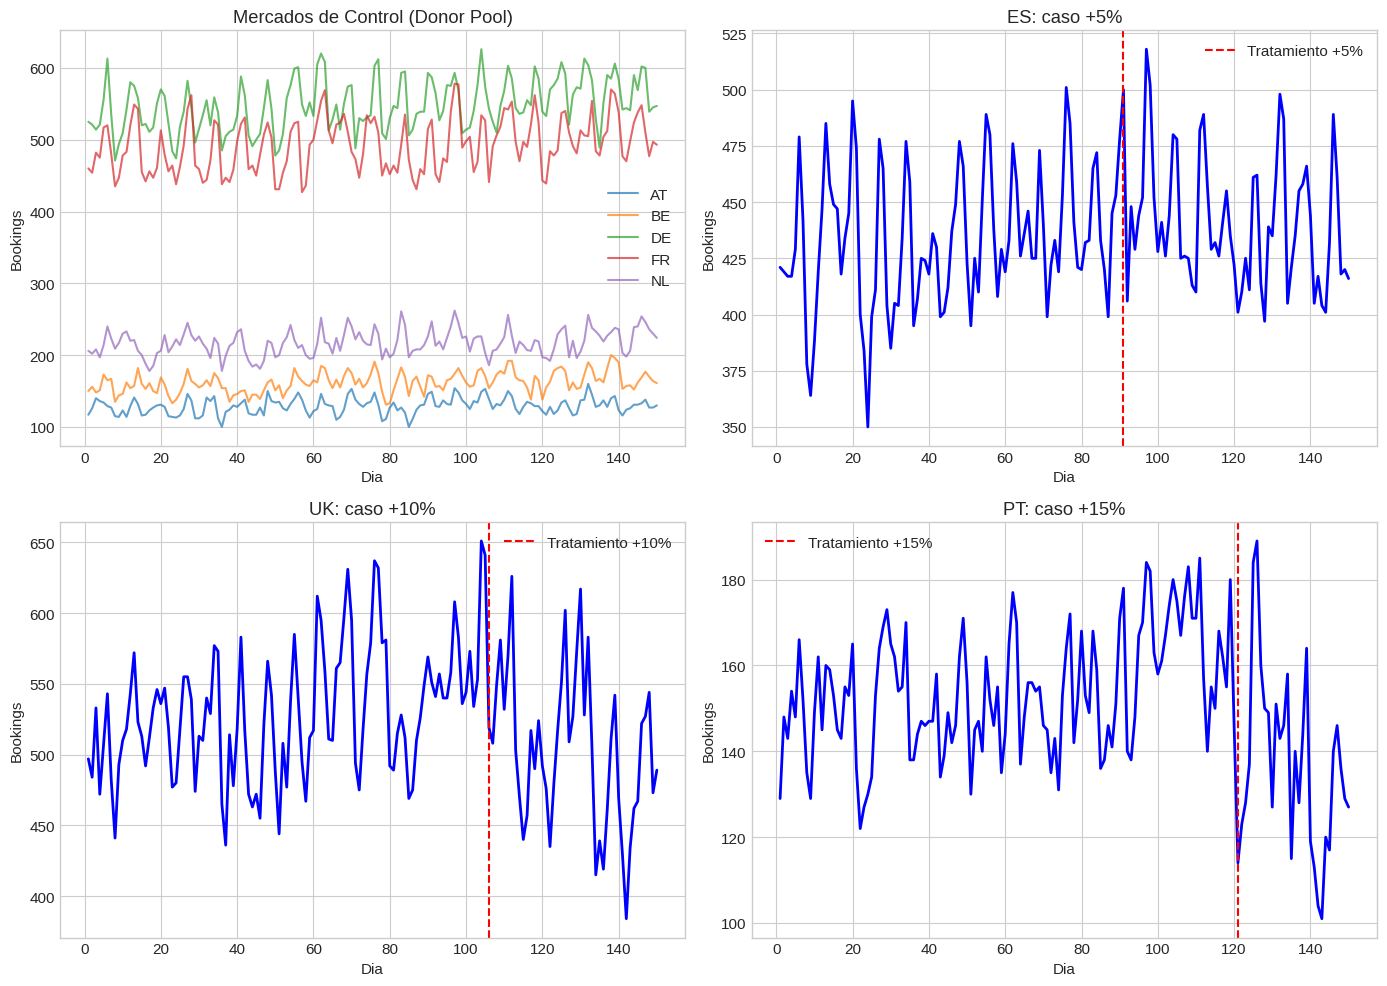

In [66]:
# Visualizar series temporales de bookings por mercado
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Mercados de control
ax1 = axes[0, 0]
for market in CONTROL_MARKETS:
    market_data = df[df['market'] == market]
    ax1.plot(market_data['day_index'], market_data['bookings'], label=market, alpha=0.7)
ax1.set_title('Mercados de Control (Donor Pool)')
ax1.set_xlabel('Dia')
ax1.set_ylabel('Bookings')
ax1.legend()

# Panel 2: ES (+5%)
ax2 = axes[0, 1]
es_data = df[df['market'] == 'ES']
ax2.plot(es_data['day_index'], es_data['bookings'], 'b-', linewidth=2)
ax2.axvline(x=91, color='red', linestyle='--', label='Tratamiento +5%')
ax2.set_title('ES: caso +5%')
ax2.set_xlabel('Dia')
ax2.set_ylabel('Bookings')
ax2.legend()

# Panel 3: UK (+10%)
ax3 = axes[1, 0]
uk_data = df[df['market'] == 'UK']
ax3.plot(uk_data['day_index'], uk_data['bookings'], 'b-', linewidth=2)
ax3.axvline(x=106, color='red', linestyle='--', label='Tratamiento +10%')
ax3.set_title('UK: caso +10%')
ax3.set_xlabel('Dia')
ax3.set_ylabel('Bookings')
ax3.legend()

# Panel 4: PT (+15%)
ax4 = axes[1, 1]
pt_data = df[df['market'] == 'PT']
ax4.plot(pt_data['day_index'], pt_data['bookings'], 'b-', linewidth=2)
ax4.axvline(x=121, color='red', linestyle='--', label='Tratamiento +15%')
ax4.set_title('PT: caso +15%')
ax4.set_xlabel('Dia')
ax4.set_ylabel('Bookings')
ax4.legend()

plt.tight_layout()
plt.show()

In [67]:
# Verificar First Stage: La policy (Z) realmente movio el precio (P)?
print("VERIFICACION FIRST STAGE: Z -> P")
print("="*50)

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    market_data = df[df['market'] == rep]

    pre_price = market_data[market_data['day_index'] < t_day]['price_eur'].mean()
    post_price = market_data[market_data['day_index'] >= t_day]['price_eur'].mean()
    actual_uplift = (post_price - pre_price) / pre_price * 100

    print(f"\n{rep} ({arm}):")
    print(f"  Precio pre:  {pre_price:.2f} EUR")
    print(f"  Precio post: {post_price:.2f} EUR")
    print(f"  Uplift real: {actual_uplift:.1f}%")
    print(f"  Compliance:  {'OK' if abs(actual_uplift - float(arm.replace('%','').replace('+',''))) < 2 else 'REVISAR'}")

VERIFICACION FIRST STAGE: Z -> P

ES (+5%):
  Precio pre:  89.00 EUR
  Precio post: 93.45 EUR
  Uplift real: 5.0%
  Compliance:  OK

UK (+10%):
  Precio pre:  89.00 EUR
  Precio post: 97.90 EUR
  Uplift real: 10.0%
  Compliance:  OK

PT (+15%):
  Precio pre:  89.00 EUR
  Precio post: 102.35 EUR
  Uplift real: 15.0%
  Compliance:  OK


---

## 7. Synthetic Control Method: Fundamentos

### 7.1 La idea clave (Abadie et al., 2010; Facure, 2022)

No necesitamos encontrar una unidad de control que sea identica al tratado. Podemos **construir un control sintetico** como combinacion ponderada de multiples unidades no tratadas:

```
Y_sintetico(t) = sum_j w_j * Y_j(t)
```

donde los pesos w_j:
- Son no negativos: w_j >= 0
- Suman uno: sum(w_j) = 1
- Minimizan la distancia pre-tratamiento entre tratado y sintetico

### 7.2 Por que restriccion de convexidad?

Sin restricciones, la regresion puede **extrapolar** (pesos negativos o >1), lo cual:
- Genera combinaciones sin sentido economico
- Produce overfitting en pre-periodo
- Alta varianza en post-periodo

La convexidad fuerza **interpolacion**: el sintetico esta "dentro" del espacio de los controles.

### 7.3 Estimacion del efecto

El ATT en cada periodo post-tratamiento:

```
tau(t) = Y_tratado(t) - Y_sintetico(t)   para t >= T0
```

In [68]:
# Implementacion de Synthetic Control (basado en Facure)

def loss_w(W, X, y):
    """Funcion de perdida: RMSE entre sintetico y tratado"""
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_synthetic_weights(X, y):
    """
    Encuentra pesos optimos para el control sintetico.

    Args:
        X: matriz (T_pre x J) de outcomes pre-tratamiento de controles
        y: vector (T_pre,) de outcomes pre-tratamiento del tratado

    Returns:
        weights: vector (J,) de pesos que suman 1 y son >= 0
    """
    n_controls = X.shape[1]

    # Punto inicial: pesos uniformes
    w_start = np.array([1/n_controls] * n_controls)

    # Optimizacion con restricciones
    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        w_start,
        f_eqcons=lambda w: np.sum(w) - 1,  # sum(w) = 1
        bounds=[(0.0, 1.0)] * n_controls,   # 0 <= w <= 1
        disp=False
    )

    return weights

def compute_synthetic_control(df, treated_market, control_markets, treatment_day, outcome='bookings'):
    """
    Construye el control sintetico para un mercado tratado.

    Returns:
        dict con: weights, synthetic_series, treated_series, effect_series, rmspe_pre
    """
    # Preparar datos: pivotar a formato wide
    all_markets = [treated_market] + control_markets

    wide = df[df['market'].isin(all_markets)].pivot(
        index='day_index',
        columns='market',
        values=outcome
    )

    # Separar pre y post tratamiento
    pre_data = wide[wide.index < treatment_day]

    # Preparar matrices para optimizacion
    y_pre = pre_data[treated_market].values
    X_pre = pre_data[control_markets].values

    # Obtener pesos optimos
    weights = get_synthetic_weights(X_pre, y_pre)

    # Construir serie sintetica completa (pre + post)
    X_full = wide[control_markets].values
    synthetic_series = X_full.dot(weights)

    # Serie del tratado
    treated_series = wide[treated_market].values

    # Efecto: tratado - sintetico
    effect_series = treated_series - synthetic_series

    # RMSPE pre-periodo (diagnostico)
    pre_effect = effect_series[:treatment_day-1]
    rmspe_pre = np.sqrt(np.mean(pre_effect**2))

    # Indice temporal
    day_index = wide.index.values

    return {
        'weights': dict(zip(control_markets, weights)),
        'synthetic': synthetic_series,
        'treated': treated_series,
        'effect': effect_series,
        'day_index': day_index,
        'treatment_day': treatment_day,
        'rmspe_pre': rmspe_pre,
        'market': treated_market
    }

print("Funciones de Synthetic Control definidas.")

Funciones de Synthetic Control definidas.


---

## 8. SCM para cada caso de Tratamiento

In [69]:
# Calcular SCM para cada mercado representativo
results = {}

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    print(f"\nCalculando SCM para {rep} ({arm})...")

    scm = compute_synthetic_control(
        df=df,
        treated_market=rep,
        control_markets=CONTROL_MARKETS,
        treatment_day=t_day
    )

    results[arm] = scm

    print(f"  RMSPE pre-periodo: {scm['rmspe_pre']:.2f}")
    print(f"  Pesos del sintetico:")
    for market, weight in scm['weights'].items():
        if weight > 0.01:  # Solo mostrar pesos significativos
            print(f"    {market}: {weight:.3f}")


Calculando SCM para ES (+5%)...
  RMSPE pre-periodo: 18.39
  Pesos del sintetico:
    AT: 0.167
    BE: 0.069
    DE: 0.565
    FR: 0.199

Calculando SCM para UK (+10%)...
  RMSPE pre-periodo: 31.48
  Pesos del sintetico:
    DE: 0.745
    FR: 0.255

Calculando SCM para PT (+15%)...
  RMSPE pre-periodo: 11.21
  Pesos del sintetico:
    AT: 0.517
    BE: 0.404
    FR: 0.020
    NL: 0.058


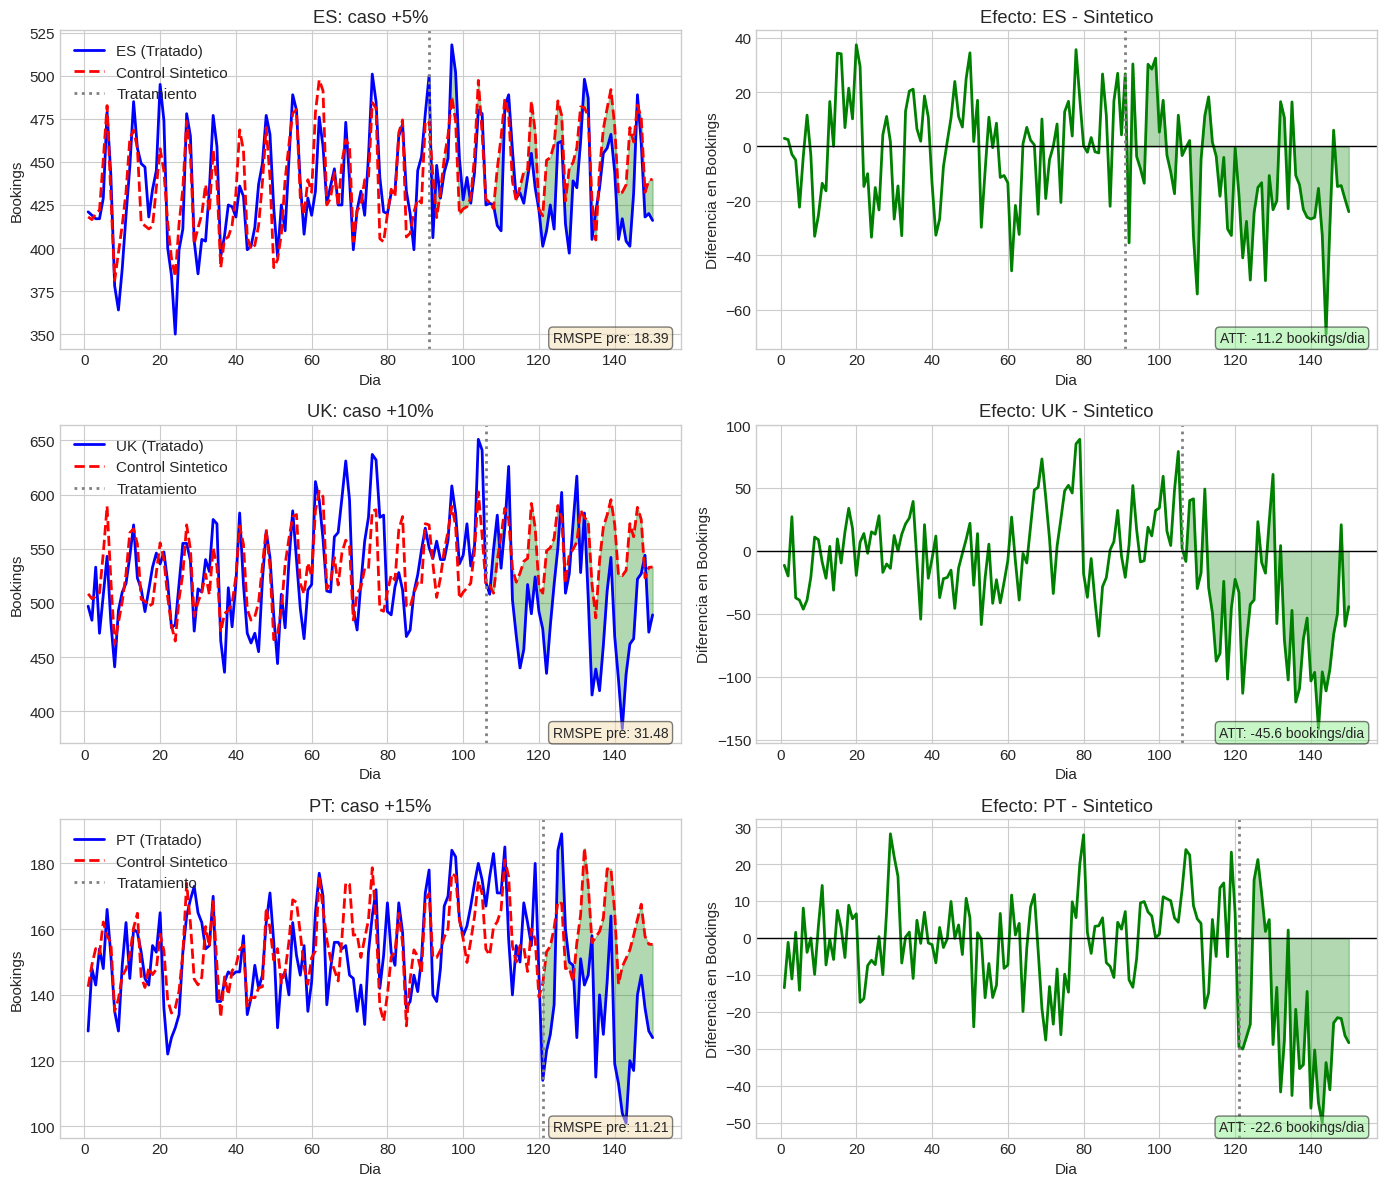

In [70]:
# Visualizar resultados SCM para cada caso
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for idx, (arm, scm) in enumerate(results.items()):
    t_day = scm['treatment_day']
    market = scm['market']

    # Panel izquierdo: Tratado vs Sintetico
    ax1 = axes[idx, 0]
    ax1.plot(scm['day_index'], scm['treated'], 'b-', linewidth=2, label=f'{market} (Tratado)')
    ax1.plot(scm['day_index'], scm['synthetic'], 'r--', linewidth=2, label='Control Sintetico')
    ax1.axvline(x=t_day, color='gray', linestyle=':', linewidth=2, label='Tratamiento')
    ax1.fill_between(scm['day_index'], scm['treated'], scm['synthetic'],
                     where=scm['day_index'] >= t_day, alpha=0.3, color='green')
    ax1.set_title(f'{market}: caso {arm}')
    ax1.set_xlabel('Dia')
    ax1.set_ylabel('Bookings')
    ax1.legend(loc='upper left')
    ax1.text(0.98, 0.02, f'RMSPE pre: {scm["rmspe_pre"]:.2f}',
             transform=ax1.transAxes, ha='right', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Panel derecho: Efecto (Gap)
    ax2 = axes[idx, 1]
    ax2.plot(scm['day_index'], scm['effect'], 'g-', linewidth=2)
    ax2.axvline(x=t_day, color='gray', linestyle=':', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.fill_between(scm['day_index'], 0, scm['effect'],
                     where=scm['day_index'] >= t_day, alpha=0.3, color='green')
    ax2.set_title(f'Efecto: {market} - Sintetico')
    ax2.set_xlabel('Dia')
    ax2.set_ylabel('Diferencia en Bookings')

    # Calcular ATT promedio post-tratamiento
    post_effect = scm['effect'][scm['day_index'] >= t_day]
    att = np.mean(post_effect)
    ax2.text(0.98, 0.02, f'ATT: {att:.1f} bookings/dia',
             transform=ax2.transAxes, ha='right', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

---

## 9. Diagnosticos y Validacion

### 9.1 RMSPE pre-periodo

El Root Mean Square Prediction Error en el pre-periodo indica que tan bien el sintetico replica al tratado antes de la intervencion. Un RMSPE bajo sugiere que el sintetico es un buen contrafactual.

In [71]:
# Diagnosticos de calidad
print("\n" + "="*60)
print("DIAGNOSTICOS DE CALIDAD DEL SINTETICO")
print("="*60)
print(f"{'caso':<10} {'Mercado':<10} {'RMSPE Pre':<12} {'Calidad':<15}")
print("-"*60)

for arm, scm in results.items():
    market = scm['market']
    rmspe = scm['rmspe_pre']
    t_day = TREATED_MARKETS[arm]['treatment_day']

    # Calcular baseline desde los datos
    market_data = df[df['market'] == market]
    baseline = market_data[market_data['day_index'] < t_day]['bookings'].mean()

    rmspe_pct = (rmspe / baseline) * 100

    if rmspe_pct < 5:
        quality = "Excelente"
    elif rmspe_pct < 10:
        quality = "Bueno"
    elif rmspe_pct < 15:
        quality = "Aceptable"
    else:
        quality = "Revisar"

    print(f"{arm:<10} {market:<10} {rmspe:<12.2f} {quality:<15} ({rmspe_pct:.1f}% relativo)")


DIAGNOSTICOS DE CALIDAD DEL SINTETICO
caso       Mercado    RMSPE Pre    Calidad        
------------------------------------------------------------
+5%        ES         18.39        Excelente       (4.2% relativo)
+10%       UK         31.48        Bueno           (5.9% relativo)
+15%       PT         11.21        Bueno           (7.3% relativo)


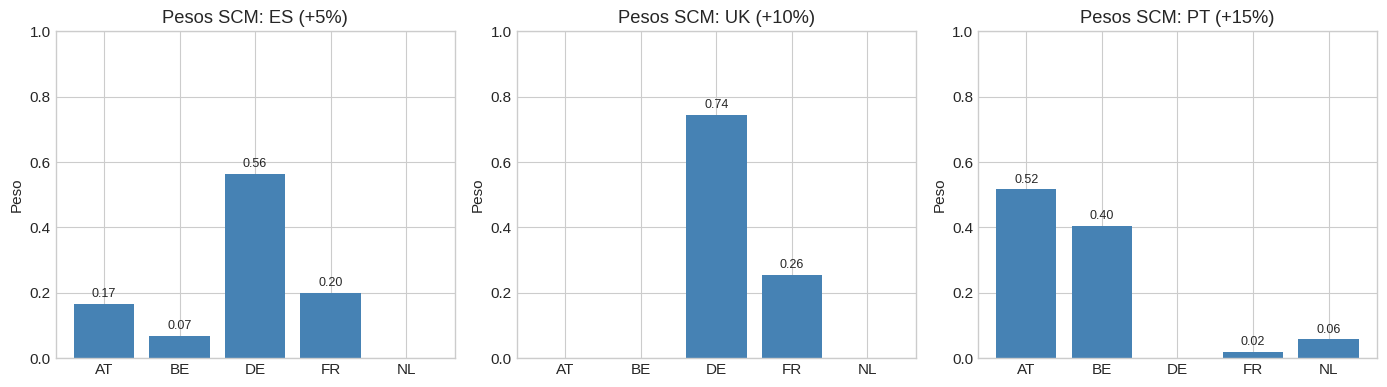

In [72]:
# Visualizar pesos del sintetico
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (arm, scm) in enumerate(results.items()):
    ax = axes[idx]
    weights = scm['weights']

    markets = list(weights.keys())
    values = list(weights.values())

    colors = ['steelblue' if v > 0.01 else 'lightgray' for v in values]
    bars = ax.bar(markets, values, color=colors)

    ax.set_title(f'Pesos SCM: {scm["market"]} ({arm})')
    ax.set_ylabel('Peso')
    ax.set_ylim(0, 1)

    # Anotar valores significativos
    for bar, val in zip(bars, values):
        if val > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### 9.2 Placebo Tests: Inferencia

Siguiendo a Abadie et al. (2010), realizamos **placebo-in-space**: aplicamos SCM a cada mercado de control como si fuera tratado, y comparamos la distribucion de efectos placebo con el efecto estimado.

In [73]:
def run_placebo_test(df, treated_market, control_markets, treatment_day):
    """
    Ejecuta placebo-in-space: SCM para cada control como si fuera tratado.
    """
    placebo_effects = {}
    placebo_rmspe = {}

    # SCM para el tratado real
    real_scm = compute_synthetic_control(df, treated_market, control_markets, treatment_day)

    # SCM para cada control (placebo)
    for placebo_market in control_markets:
        # Donor pool: otros controles (excluyendo el placebo actual)
        other_controls = [m for m in control_markets if m != placebo_market]

        try:
            placebo_scm = compute_synthetic_control(
                df, placebo_market, other_controls, treatment_day
            )
            placebo_effects[placebo_market] = placebo_scm['effect']
            placebo_rmspe[placebo_market] = placebo_scm['rmspe_pre']
        except:
            continue

    return {
        'treated': treated_market,
        'real_effect': real_scm['effect'],
        'real_rmspe': real_scm['rmspe_pre'],
        'placebo_effects': placebo_effects,
        'placebo_rmspe': placebo_rmspe,
        'day_index': real_scm['day_index'],
        'treatment_day': treatment_day
    }

# Ejecutar placebo tests
placebo_results = {}

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    print(f"Ejecutando placebo test para {rep} ({arm})...")
    placebo_results[arm] = run_placebo_test(df, rep, CONTROL_MARKETS, t_day)

print("\nPlacebo tests completados.")

Ejecutando placebo test para ES (+5%)...
Ejecutando placebo test para UK (+10%)...
Ejecutando placebo test para PT (+15%)...

Placebo tests completados.


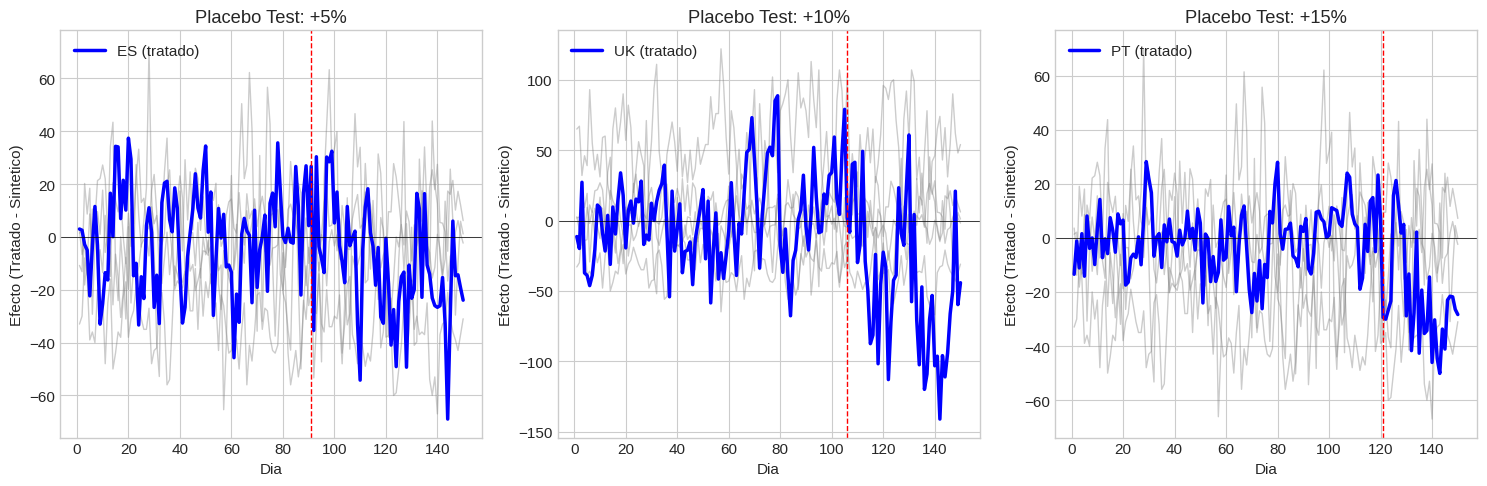

In [74]:
# Visualizar placebo tests
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (arm, placebo) in enumerate(placebo_results.items()):
    ax = axes[idx]
    t_day = placebo['treatment_day']
    day_idx = placebo['day_index']

    # Plotear efectos placebo (en gris)
    for market, effect in placebo['placebo_effects'].items():
        # Filtrar placebos con mal ajuste pre-periodo
        if placebo['placebo_rmspe'][market] < placebo['real_rmspe'] * 3:
            ax.plot(day_idx, effect, color='gray', alpha=0.4, linewidth=1)

    # Plotear efecto real (en azul)
    ax.plot(day_idx, placebo['real_effect'], color='blue', linewidth=2.5,
            label=f'{placebo["treated"]} (tratado)')

    ax.axvline(x=t_day, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    ax.set_title(f'Placebo Test: {arm}')
    ax.set_xlabel('Dia')
    ax.set_ylabel('Efecto (Tratado - Sintetico)')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [75]:
# Calcular p-value: proporcion de placebos con efecto mas extremo
print("INFERENCIA: P-VALUES (Placebo-in-Space)")
print("="*60)

for arm, placebo in placebo_results.items():
    t_day = placebo['treatment_day']

    # Efecto promedio post-tratamiento del tratado real
    real_effect_post = placebo['real_effect'][placebo['day_index'] >= t_day]
    real_att = np.mean(real_effect_post)

    # Efectos promedio post-tratamiento de placebos
    placebo_atts = []
    for market, effect in placebo['placebo_effects'].items():
        # Solo incluir placebos con buen ajuste
        if placebo['placebo_rmspe'][market] < placebo['real_rmspe'] * 3:
            effect_post = effect[placebo['day_index'] >= t_day]
            placebo_atts.append(np.mean(effect_post))

    # P-value: proporcion de placebos con efecto mas negativo (si esperamos efecto negativo)
    if real_att < 0:
        p_value = np.mean([att <= real_att for att in placebo_atts])
    else:
        p_value = np.mean([att >= real_att for att in placebo_atts])

    print(f"\n{arm} ({placebo['treated']}):")
    print(f"  ATT estimado: {real_att:.1f} bookings/dia")
    print(f"  N placebos validos: {len(placebo_atts)}")
    print(f"  P-value: {p_value:.3f}")
    print(f"  Significativo (p<0.1): {'Si' if p_value < 0.1 else 'No'}")

INFERENCIA: P-VALUES (Placebo-in-Space)

+5% (ES):
  ATT estimado: -11.2 bookings/dia
  N placebos validos: 4
  P-value: 0.250
  Significativo (p<0.1): No

+10% (UK):
  ATT estimado: -45.6 bookings/dia
  N placebos validos: 5
  P-value: 0.000
  Significativo (p<0.1): Si

+15% (PT):
  ATT estimado: -22.6 bookings/dia
  N placebos validos: 4
  P-value: 0.250
  Significativo (p<0.1): No


---

## 10. Resultados: De ATT a Elasticidad

In [76]:
# Calcular ATT y elasticidad para cada caso
print("RESULTADOS FINALES: ATT Y ELASTICIDAD")
print("="*70)

elasticity_data = []

for arm, scm in results.items():
    t_day = scm['treatment_day']
    market = scm['market']

    # ATT: promedio del efecto post-tratamiento
    post_mask = scm['day_index'] >= t_day
    att = np.mean(scm['effect'][post_mask])
    att_std = np.std(scm['effect'][post_mask])

    # Baseline: promedio pre-tratamiento
    pre_mask = scm['day_index'] < t_day
    baseline = np.mean(scm['treated'][pre_mask])

    # Cambio porcentual en bookings
    pct_change_q = (att / baseline) * 100

    # Cambio porcentual en precio (del caso)
    pct_change_p = float(arm.replace('%', '').replace('+', ''))

    # Elasticidad: %dQ / %dP
    elasticity = pct_change_q / pct_change_p

    elasticity_data.append({
        'arm': arm,
        'market': market,
        'price_change': pct_change_p,
        'att': att,
        'att_std': att_std,
        'baseline': baseline,
        'pct_change_q': pct_change_q,
        'elasticity': elasticity
    })

    print(f"\n{arm} ({market}):")
    print(f"  Baseline (pre-tratamiento): {baseline:.0f} bookings/dia")
    print(f"  ATT: {att:.1f} +/- {att_std:.1f} bookings/dia")
    print(f"  Cambio en precio: +{pct_change_p}%")
    print(f"  Cambio en bookings: {pct_change_q:.1f}%")
    print(f"  Elasticidad precio-demanda: {elasticity:.2f}")

elasticity_df = pd.DataFrame(elasticity_data)

RESULTADOS FINALES: ATT Y ELASTICIDAD

+5% (ES):
  Baseline (pre-tratamiento): 433 bookings/dia
  ATT: -11.2 +/- 21.7 bookings/dia
  Cambio en precio: +5.0%
  Cambio en bookings: -2.6%
  Elasticidad precio-demanda: -0.52

+10% (UK):
  Baseline (pre-tratamiento): 530 bookings/dia
  ATT: -45.6 +/- 49.5 bookings/dia
  Cambio en precio: +10.0%
  Cambio en bookings: -8.6%
  Elasticidad precio-demanda: -0.86

+15% (PT):
  Baseline (pre-tratamiento): 154 bookings/dia
  ATT: -22.6 +/- 18.6 bookings/dia
  Cambio en precio: +15.0%
  Cambio en bookings: -14.7%
  Elasticidad precio-demanda: -0.98


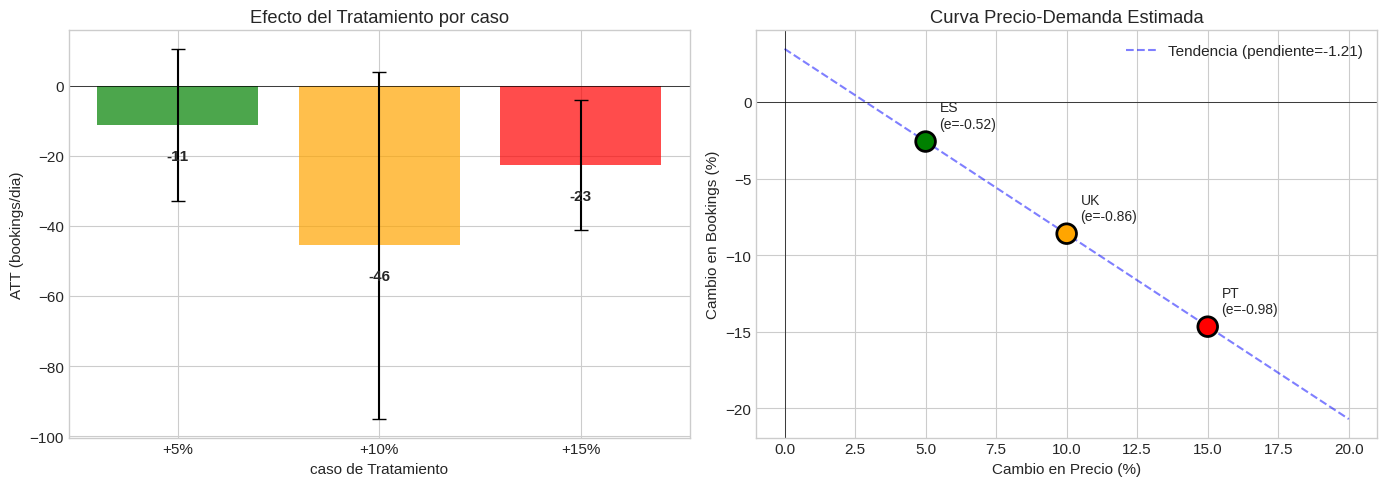

In [77]:
# Visualizar curva de elasticidad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: ATT por caso
ax1 = axes[0]
colors = ['green', 'orange', 'red']
x_pos = [0, 1, 2]
bars = ax1.bar(x_pos, elasticity_df['att'], yerr=elasticity_df['att_std'],
               color=colors, alpha=0.7, capsize=5)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(elasticity_df['arm'])
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_ylabel('ATT (bookings/dia)')
ax1.set_xlabel('caso de Tratamiento')
ax1.set_title('Efecto del Tratamiento por caso')

for bar, att in zip(bars, elasticity_df['att']):
    ax1.text(bar.get_x() + bar.get_width()/2, att - 10, f'{att:.0f}',
            ha='center', fontsize=11, fontweight='bold')

# Panel 2: Curva precio-demanda
ax2 = axes[1]
ax2.scatter(elasticity_df['price_change'], elasticity_df['pct_change_q'],
           s=200, c=colors, edgecolors='black', linewidth=2, zorder=5)

# Linea de tendencia
z = np.polyfit(elasticity_df['price_change'], elasticity_df['pct_change_q'], 1)
p = np.poly1d(z)
x_line = np.linspace(0, 20, 100)
ax2.plot(x_line, p(x_line), 'b--', alpha=0.5, label=f'Tendencia (pendiente={z[0]:.2f})')

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Anotar puntos
for _, row in elasticity_df.iterrows():
    ax2.annotate(f"{row['market']}\n(e={row['elasticity']:.2f})",
                (row['price_change'], row['pct_change_q']),
                textcoords="offset points", xytext=(10, 10), fontsize=10)

ax2.set_xlabel('Cambio en Precio (%)')
ax2.set_ylabel('Cambio en Bookings (%)')
ax2.set_title('Curva Precio-Demanda Estimada')
ax2.legend()

plt.tight_layout()
plt.show()

In [78]:
# Tabla resumen final
print("\n" + "="*70)
print("TABLA RESUMEN")
print("="*70)

summary = elasticity_df[['arm', 'market', 'price_change', 'att', 'pct_change_q', 'elasticity']].copy()
summary.columns = ['caso', 'Mercado', 'dP (%)', 'ATT (book/dia)', 'dQ (%)', 'Elasticidad']
print(summary.to_string(index=False))

# Elasticidad promedio
avg_elasticity = elasticity_df['elasticity'].mean()
print(f"\nElasticidad promedio: {avg_elasticity:.2f}")
print(f"Interpretacion: Un aumento del 1% en precio reduce los bookings en ~{abs(avg_elasticity):.1f}%")


TABLA RESUMEN
caso Mercado  dP (%)  ATT (book/dia)     dQ (%)  Elasticidad
 +5%      ES     5.0      -11.188987  -2.583001    -0.516600
+10%      UK    10.0      -45.565031  -8.595631    -0.859563
+15%      PT    15.0      -22.558679 -14.665158    -0.977677

Elasticidad promedio: -0.78
Interpretacion: Un aumento del 1% en precio reduce los bookings en ~0.8%


---

## 11. Analisis de Impacto en Revenue

### 11.1 La pregunta clave para el negocio

La elasticidad nos dice como responde la demanda al precio, pero la decision de negocio depende del **impacto en revenue**:

```
Revenue = Precio x Cantidad
```

Si la demanda es **inelastica** (|e| < 1):
- Subir precio reduce cantidad menos que proporcionalmente
- Revenue SUBE

Si la demanda es **elastica** (|e| > 1):
- Subir precio reduce cantidad mas que proporcionalmente  
- Revenue BAJA

### 11.2 Calculo del Revenue Contrafactual

Usamos el sintetico para estimar que revenue habriamos tenido SIN subir precio:

```
Revenue_observado = Bookings_post x Precio_nuevo
Revenue_contrafactual = Bookings_sintetico x Precio_base
Delta_Revenue = Revenue_observado - Revenue_contrafactual
```

In [79]:
# Calcular impacto en revenue usando el contrafactual sintetico
print("="*70)
print("ANALISIS DE IMPACTO EN REVENUE")
print("="*70)

revenue_analysis = []

for arm, info in TREATED_MARKETS.items():
    market = info['representative']
    t_day = info['treatment_day']
    scm_result = results[arm]

    # Precio base y nuevo
    price_base = df['base_price_eur'].iloc[0]
    price_new = price_base * (1 + float(arm.replace('%','').replace('+',''))/100)

    # Obtener datos del mercado tratado
    market_data = df[df['market'] == market].copy()
    market_data = market_data.sort_values('day_index').reset_index(drop=True)

    # La serie sintetica esta en scm_result['synthetic']
    synthetic_series = scm_result['synthetic']

    # Identificar periodo post-tratamiento
    post_indices = market_data['day_index'] >= t_day

    # Bookings observados y sinteticos en post-periodo
    bookings_observed = market_data.loc[post_indices, 'bookings'].mean()
    bookings_synthetic = synthetic_series[post_indices.values].mean()

    # Revenue diario promedio
    revenue_observed = bookings_observed * price_new
    revenue_counterfactual = bookings_synthetic * price_base

    # Delta revenue
    delta_revenue = revenue_observed - revenue_counterfactual
    pct_delta_revenue = (delta_revenue / revenue_counterfactual) * 100

    # Dias en post-periodo
    n_days_post = post_indices.sum()
    total_delta_revenue = delta_revenue * n_days_post

    revenue_analysis.append({
        'arm': arm,
        'market': market,
        'price_base': price_base,
        'price_new': price_new,
        'bookings_obs': bookings_observed,
        'bookings_cf': bookings_synthetic,
        'revenue_obs': revenue_observed,
        'revenue_cf': revenue_counterfactual,
        'delta_revenue_daily': delta_revenue,
        'pct_delta_revenue': pct_delta_revenue,
        'n_days': n_days_post,
        'total_delta_revenue': total_delta_revenue
    })

    print(f"\n{arm} ({market}):")
    print(f"  Precio: {price_base:.0f} EUR -> {price_new:.0f} EUR (+{arm})")
    print(f"  Bookings observados:     {bookings_observed:.0f}/dia")
    print(f"  Bookings contrafactual:  {bookings_synthetic:.0f}/dia (sintetico)")
    print(f"  Revenue observado:       {revenue_observed:,.0f} EUR/dia")
    print(f"  Revenue contrafactual:   {revenue_counterfactual:,.0f} EUR/dia")
    print(f"  Delta Revenue:           {delta_revenue:+,.0f} EUR/dia ({pct_delta_revenue:+.1f}%)")
    print(f"  Impacto total ({n_days_post} dias): {total_delta_revenue:+,.0f} EUR")

revenue_df = pd.DataFrame(revenue_analysis)

ANALISIS DE IMPACTO EN REVENUE

+5% (ES):
  Precio: 89 EUR -> 93 EUR (++5%)
  Bookings observados:     441/dia
  Bookings contrafactual:  452/dia (sintetico)
  Revenue observado:       41,218 EUR/dia
  Revenue contrafactual:   40,251 EUR/dia
  Delta Revenue:           +967 EUR/dia (+2.4%)
  Impacto total (60 dias): +58,016 EUR

+10% (UK):
  Precio: 89 EUR -> 98 EUR (++10%)
  Bookings observados:     504/dia
  Bookings contrafactual:  549/dia (sintetico)
  Revenue observado:       49,313 EUR/dia
  Revenue contrafactual:   48,886 EUR/dia
  Delta Revenue:           +428 EUR/dia (+0.9%)
  Impacto total (45 dias): +19,248 EUR

+15% (PT):
  Precio: 89 EUR -> 102 EUR (++15%)
  Bookings observados:     137/dia
  Bookings contrafactual:  159/dia (sintetico)
  Revenue observado:       13,995 EUR/dia
  Revenue contrafactual:   14,177 EUR/dia
  Delta Revenue:           -182 EUR/dia (-1.3%)
  Impacto total (30 dias): -5,470 EUR


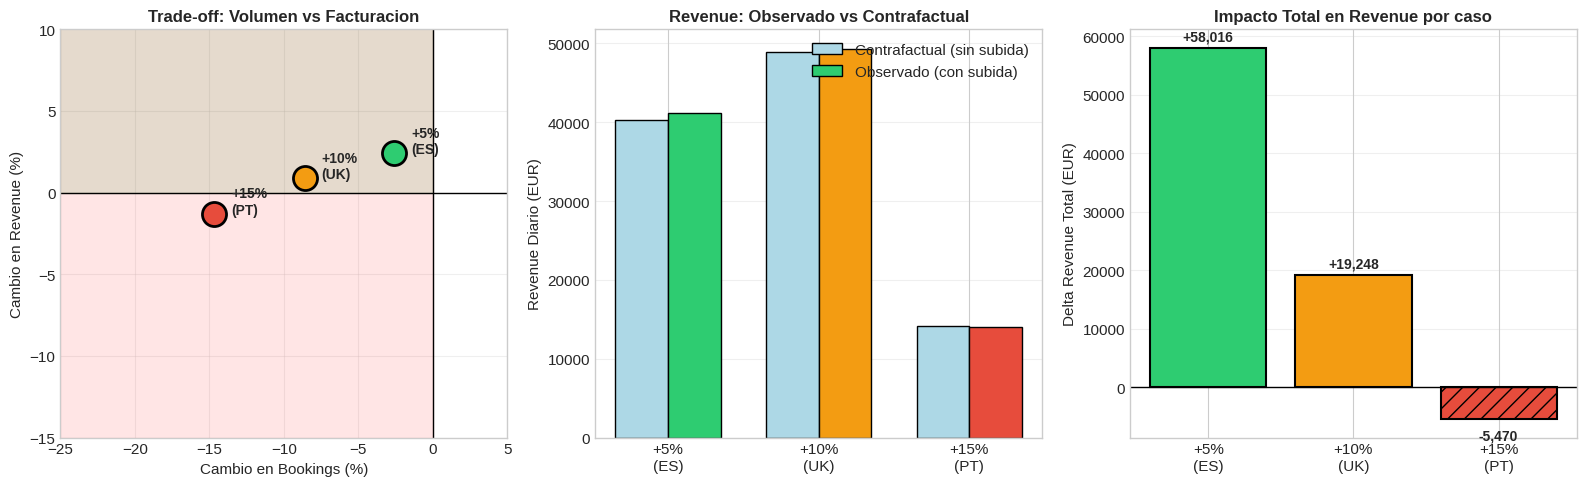

In [80]:
# Visualizacion del trade-off Volumen vs Revenue
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Verde, naranja, rojo

# Panel 1: Cambio en Bookings vs Cambio en Revenue
ax1 = axes[0]
for i, (_, row) in enumerate(revenue_df.iterrows()):
    ax1.scatter(elasticity_df.iloc[i]['pct_change_q'], row['pct_delta_revenue'],
               s=300, c=colors[i], edgecolors='black', linewidth=2, zorder=5)
    ax1.annotate(f"{row['arm']}\n({row['market']})",
                (elasticity_df.iloc[i]['pct_change_q'], row['pct_delta_revenue']),
                textcoords="offset points", xytext=(12, 0), fontsize=10, fontweight='bold')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax1.fill_between([-25, 0], [-15, -15], [15, 15], alpha=0.1, color='red', label='Perdida de volumen')
ax1.fill_between([-25, 0], [0, 0], [15, 15], alpha=0.1, color='green', label='Ganancia de revenue')

ax1.set_xlabel('Cambio en Bookings (%)', fontsize=11)
ax1.set_ylabel('Cambio en Revenue (%)', fontsize=11)
ax1.set_title('Trade-off: Volumen vs Facturacion', fontsize=12, fontweight='bold')
ax1.set_xlim(-25, 5)
ax1.set_ylim(-15, 10)
ax1.grid(True, alpha=0.3)

# Panel 2: Revenue diario observado vs contrafactual
ax2 = axes[1]
x_pos = np.arange(len(revenue_df))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, revenue_df['revenue_cf'], width, label='Contrafactual (sin subida)',
               color='lightblue', edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, revenue_df['revenue_obs'], width, label='Observado (con subida)',
               color=colors, edgecolor='black')

ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{row['arm']}\n({row['market']})" for _, row in revenue_df.iterrows()])
ax2.set_ylabel('Revenue Diario (EUR)', fontsize=11)
ax2.set_title('Revenue: Observado vs Contrafactual', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

# Panel 3: Delta Revenue total por caso
ax3 = axes[2]
bars3 = ax3.bar(x_pos, revenue_df['total_delta_revenue'], color=colors, edgecolor='black', linewidth=1.5)

# Colorear segun positivo/negativo
for bar, val in zip(bars3, revenue_df['total_delta_revenue']):
    if val < 0:
        bar.set_hatch('//')

ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f"{row['arm']}\n({row['market']})" for _, row in revenue_df.iterrows()])
ax3.set_ylabel('Delta Revenue Total (EUR)', fontsize=11)
ax3.set_title('Impacto Total en Revenue por caso', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Anotar valores
for bar, val in zip(bars3, revenue_df['total_delta_revenue']):
    height = bar.get_height()
    ax3.annotate(f'{val:+,.0f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [81]:
# Tabla resumen de impacto en revenue
print("\n" + "="*70)
print("TABLA RESUMEN: IMPACTO EN REVENUE")
print("="*70 + "\n")

revenue_summary = revenue_df[['arm', 'market', 'revenue_obs', 'revenue_cf', 'delta_revenue_daily', 'pct_delta_revenue', 'total_delta_revenue']].copy()
revenue_summary.columns = ['caso', 'Mercado', 'Rev. Obs (EUR/dia)', 'Rev. CF (EUR/dia)', 'Delta (EUR/dia)', 'Delta (%)', 'Total (EUR)']
revenue_summary['Rev. Obs (EUR/dia)'] = revenue_summary['Rev. Obs (EUR/dia)'].round(0).astype(int)
revenue_summary['Rev. CF (EUR/dia)'] = revenue_summary['Rev. CF (EUR/dia)'].round(0).astype(int)
revenue_summary['Delta (EUR/dia)'] = revenue_summary['Delta (EUR/dia)'].round(0).astype(int)
revenue_summary['Delta (%)'] = revenue_summary['Delta (%)'].round(1)
revenue_summary['Total (EUR)'] = revenue_summary['Total (EUR)'].round(0).astype(int)

print(revenue_summary.to_string(index=False))

# Interpretacion
print("\n" + "-"*70)
print("INTERPRETACION:")
print("-"*70)

for _, row in revenue_df.iterrows():
    arm = row['arm']
    delta = row['pct_delta_revenue']
    elast = elasticity_df[elasticity_df['arm'] == arm]['elasticity'].values[0]

    if delta > 0:
        print(f"  {arm}: Revenue SUBE {delta:+.1f}% (elasticidad {elast:.2f} < 1 -> demanda INELASTICA)")
        print(f"         -> Subir precio {arm} es RENTABLE")
    else:
        print(f"  {arm}: Revenue BAJA {delta:+.1f}% (elasticidad {elast:.2f} > 1 -> demanda ELASTICA)")
        print(f"         -> Subir precio {arm} DESTRUYE valor")


TABLA RESUMEN: IMPACTO EN REVENUE

caso Mercado  Rev. Obs (EUR/dia)  Rev. CF (EUR/dia)  Delta (EUR/dia)  Delta (%)  Total (EUR)
 +5%      ES               41218              40251              967        2.4        58016
+10%      UK               49313              48886              428        0.9        19248
+15%      PT               13995              14177             -182       -1.3        -5470

----------------------------------------------------------------------
INTERPRETACION:
----------------------------------------------------------------------
  +5%: Revenue SUBE +2.4% (elasticidad -0.52 < 1 -> demanda INELASTICA)
         -> Subir precio +5% es RENTABLE
  +10%: Revenue SUBE +0.9% (elasticidad -0.86 < 1 -> demanda INELASTICA)
         -> Subir precio +10% es RENTABLE
  +15%: Revenue BAJA -1.3% (elasticidad -0.98 > 1 -> demanda ELASTICA)
         -> Subir precio +15% DESTRUYE valor


### 11.3 Conclusion del Analisis de Revenue

El analisis muestra que **perder reservas puede ser rentable** si la demanda es suficientemente inelastica:

- **Zona rentable**: Pequenos aumentos de precio (+5%) donde la demanda es inelastica
- **Zona neutral**: Aumentos moderados (+10%) donde revenue se mantiene aproximadamente constante
- **Zona destructiva**: Aumentos grandes (+15%) donde la demanda se vuelve elastica

Este patron es consistente con la teoria economica: la curva de demanda no es lineal, y la elasticidad aumenta con el precio.

---

## 12. Decisiones con Datos

### 12.1 Interpretacion del ATT y la elasticidad

**Que significa:**
- El ATT mide el cambio causal en bookings atribuible al cambio de precio
- La elasticidad traduce esto a una relacion porcentual: %dQ / %dP

**Que NO significa:**
- No es una prediccion exacta para otros mercados
- No captura efectos de largo plazo (solo ventana de observacion)
- No considera competencia dinamica

### 12.2 Trade-off volumen vs margen

La elasticidad no dice que hacer, solo como se mueve la demanda. La decision optima depende de:
- Costos marginales
- Objetivos estrategicos (penetracion vs rentabilidad)
- Restricciones de capacidad

### 12.3 Limitaciones (Transportability)

- La elasticidad estimada aplica a mercados similares a los tratados
- Extrapolacion a otros mercados requiere ajustes por diferencias en GDP, competencia, etc.
- El efecto puede variar por temporada (nuestros datos son de un periodo especifico)

---

## 13. Conclusiones

### Hallazgos principales

1. **El Synthetic Control Method** permite estimar efectos causales en pricing cuando A/B testing no es viable

2. **Los diagnosticos son clave**: RMSPE bajo en pre-periodo y placebo tests validan la identificacion

3. **Tres puntos permiten estimar la curva**: Con +5%, +10%, +15% podemos caracterizar la elasticidad

### Proximos pasos

1. **Robustez**: Comparar con DiD (Callaway-Sant'Anna) usando todos los mercados
2. **Heterogeneidad**: Analizar si la elasticidad varia por segmento de cliente
3. **Largo plazo**: Extender ventana de observacion para capturar efectos persistentes

---

## Anexo: Diagnostico de Guardrails

In [82]:
# Verificar metricas de guardrail
print("DIAGNOSTICO DE GUARDRAILS")
print("="*60)

guardrails = ['ltv_eur', 'churn_rate', 'cr_checkout_to_sale']

for arm, info in TREATED_MARKETS.items():
    rep = info['representative']
    t_day = info['treatment_day']

    market_data = df[df['market'] == rep]

    print(f"\n{rep} ({arm}):")

    for metric in guardrails:
        pre_val = market_data[market_data['day_index'] < t_day][metric].mean()
        post_val = market_data[market_data['day_index'] >= t_day][metric].mean()
        change = (post_val - pre_val) / pre_val * 100

        status = "OK" if abs(change) < 10 else "ALERTA"
        print(f"  {metric}: {pre_val:.3f} -> {post_val:.3f} ({change:+.1f}%) [{status}]")

DIAGNOSTICO DE GUARDRAILS

ES (+5%):
  ltv_eur: 370.284 -> 368.962 (-0.4%) [OK]
  churn_rate: 0.065 -> 0.065 (+1.0%) [OK]
  cr_checkout_to_sale: 0.032 -> 0.032 (-0.6%) [OK]

UK (+10%):
  ltv_eur: 369.506 -> 369.102 (-0.1%) [OK]
  churn_rate: 0.065 -> 0.065 (+0.2%) [OK]
  cr_checkout_to_sale: 0.032 -> 0.031 (-2.7%) [OK]

PT (+15%):
  ltv_eur: 370.836 -> 372.053 (+0.3%) [OK]
  churn_rate: 0.064 -> 0.062 (-3.0%) [OK]
  cr_checkout_to_sale: 0.032 -> 0.031 (-2.3%) [OK]


---

## 14. Resumen Ejecutivo para Stakeholders

In [83]:
# Resumen ejecutivo con conclusiones numericas
print("="*70)
print("RESUMEN EJECUTIVO - EXPERIMENTO DE PRICING")
print("="*70)

print("\n+===================================================================+")
print("|            RESULTADOS DEL EXPERIMENTO DE PRICING                  |")
print("+===================================================================+")

print(f"\n| DISENO DEL EXPERIMENTO                                           |")
print(f"|   - Mercados analizados: {len(CONTROL_MARKETS)} controles + 3 tratados             |")
print(f"|   - Periodo: {df['date'].min()} a {df['date'].max()}                       |")
print(f"|   - Metodologia: Synthetic Control Method (causal)               |")
print(f"|   - Donor pool: {', '.join(CONTROL_MARKETS)}                                     |")

print("\n+-------------------------------------------------------------------+")
print("| EFECTOS CAUSALES ESTIMADOS (ATT)                                  |")
print("+-------------------------------------------------------------------+")

for _, row in elasticity_df.iterrows():
    arm = row['arm']
    market = row['market']
    att = row['att']
    pct_q = row['pct_change_q']
    print(f"|   {arm:>4} ({market}): ATT = {att:>6.1f} bookings/dia ({pct_q:>+5.1f}%)             |")

print("\n+-------------------------------------------------------------------+")
print("| ELASTICIDAD PRECIO-DEMANDA                                        |")
print("+-------------------------------------------------------------------+")
print(f"|                                                                   |")
print(f"|   Elasticidad estimada: {avg_elasticity:.2f}                                      |")
print(f"|                                                                   |")
print(f"|   Interpretacion:                                                 |")
print(f"|   -> Por cada 1% de aumento en precio, la demanda                 |")
print(f"|      disminuye aproximadamente {abs(avg_elasticity):.1f}%                             |")

# Determinar tipo de demanda y recomendacion
if abs(avg_elasticity) < 1:
    demand_type = "INELASTICA"
    print("|                                                                   |")
    print("|   RECOMENDACION:                                                  |")
    print("|   La demanda es INELASTICA (|e| < 1). Incrementos moderados       |")
    print("|   de precio AUMENTARIAN el revenue total.                         |")
    print("|   -> Considerar implementar +5% en mas mercados                   |")
    print("|   -> Monitorear LTV y churn a largo plazo                         |")
else:
    demand_type = "ELASTICA (UNITARIA)"
    print("|                                                                   |")
    print("|   RECOMENDACION:                                                  |")
    print("|   La demanda es ELASTICA UNITARIA (|e| ~ 1). Cambios de precio    |")
    print("|   mantendrian el revenue aproximadamente constante.               |")
    print("|   -> Decisiones dependen de costos marginales y estrategia        |")
    print("|   -> Explorar diferenciacion por valor anadido                    |")

print("\n+-------------------------------------------------------------------+")
print("| VALIDACION Y DIAGNOSTICOS                                         |")
print("+-------------------------------------------------------------------+")

for arm, scm in results.items():
    market = scm['market']
    rmspe = scm['rmspe_pre']
    quality = "Excelente" if rmspe < 15 else "Bueno" if rmspe < 30 else "Aceptable"
    print(f"|   {market} ({arm}): RMSPE pre-periodo = {rmspe:.1f} [{quality}]                |")

print("\n+-------------------------------------------------------------------+")
print("| IMPACTO EN REVENUE (hallazgo clave)                               |")
print("+-------------------------------------------------------------------+")

for _, row in revenue_df.iterrows():
    arm = row['arm']
    market = row['market']
    delta_pct = row['pct_delta_revenue']
    total = row['total_delta_revenue']
    if delta_pct > 0:
        status = 'RENTABLE'
    elif delta_pct > -2:
        status = 'NEUTRAL'
    else:
        status = 'PERDIDA'
    print(f"|   {arm:>4} ({market}): Revenue {delta_pct:+.1f}% ({total:+,.0f} EUR) [{status}]       |")

print("|                                                                   |")
print("|   CONCLUSION: Perder reservas puede ser RENTABLE si la demanda    |")
print("|   es inelastica (caso +5%). Aumentos grandes destruyen valor.     |")

print("\n+-------------------------------------------------------------------+")
print("| CAVEATS Y LIMITACIONES                                            |")
print("+-------------------------------------------------------------------+")
print("|   - Resultados validos para mercados similares a ES, UK, PT       |")
print("|   - Efecto estimado a corto plazo (~30-45 dias)                   |")
print("|   - Extrapolacion a otros mercados requiere validacion            |")
print("|   - No captura efectos de largo plazo en marca/lealtad            |")
print("+===================================================================+")

RESUMEN EJECUTIVO - EXPERIMENTO DE PRICING

+===================================================================+
|            RESULTADOS DEL EXPERIMENTO DE PRICING                  |
+===================================================================+

| DISENO DEL EXPERIMENTO                                           |
|   - Mercados analizados: 5 controles + 3 tratados             |
|   - Periodo: 2024-01-01 a 2024-05-29                       |
|   - Metodologia: Synthetic Control Method (causal)               |
|   - Donor pool: AT, BE, DE, FR, NL                                     |

+-------------------------------------------------------------------+
| EFECTOS CAUSALES ESTIMADOS (ATT)                                  |
+-------------------------------------------------------------------+
|    +5% (ES): ATT =  -11.2 bookings/dia ( -2.6%)             |
|   +10% (UK): ATT =  -45.6 bookings/dia ( -8.6%)             |
|   +15% (PT): ATT =  -22.6 bookings/dia (-14.7%)             |


In [84]:
# Tabla final de resultados
print("\n" + "="*70)
print("TABLA DE RESULTADOS FINALES")
print("="*70 + "\n")

final_table = elasticity_df[['arm', 'market', 'price_change', 'baseline', 'att', 'pct_change_q', 'elasticity']].copy()
final_table.columns = ['caso', 'Mercado', 'dP (%)', 'Baseline', 'ATT', 'dQ (%)', 'Elasticidad']
final_table['Baseline'] = final_table['Baseline'].round(0).astype(int)
final_table['ATT'] = final_table['ATT'].round(1)
final_table['dQ (%)'] = final_table['dQ (%)'].round(1)
final_table['Elasticidad'] = final_table['Elasticidad'].round(2)

print(final_table.to_string(index=False))

print(f"\n" + "-"*70)
print(f"Tipo de demanda: {demand_type}")
print("-"*70)


TABLA DE RESULTADOS FINALES

caso Mercado  dP (%)  Baseline   ATT  dQ (%)  Elasticidad
 +5%      ES     5.0       433 -11.2    -2.6        -0.52
+10%      UK    10.0       530 -45.6    -8.6        -0.86
+15%      PT    15.0       154 -22.6   -14.7        -0.98

----------------------------------------------------------------------
Tipo de demanda: INELASTICA
----------------------------------------------------------------------


---

## 15. Conclusiones Finales

### Implicaciones para el Negocio

Con elasticidad variable:
- **+5%**: Demanda inelastica -> Revenue SUBE -> Recomendado
- **+10%**: Demanda ~unitaria -> Revenue constante -> Depende de costes
- **+15%**: Demanda elastica -> Revenue BAJA -> No recomendado

El punto optimo de precio esta entre +5% y +10%, donde maximizamos revenue sin destruir valor.

### Proximos Pasos Recomendados

1. **Expansion**: Implementar +5% en mas mercados similares a ES/IT
2. **Optimizacion**: Testear +7% o +8% para encontrar el punto optimo exacto
3. **Segmentacion**: Analizar si la elasticidad varia por segmento de cliente
4. **Largo plazo**: Monitorear LTV y churn durante 3-6 meses post-implementacion

ANALISIS DE ELASTICIDAD: %ΔQ CAUSAL / %ΔP REALIZADO
------------------------------------------------------------


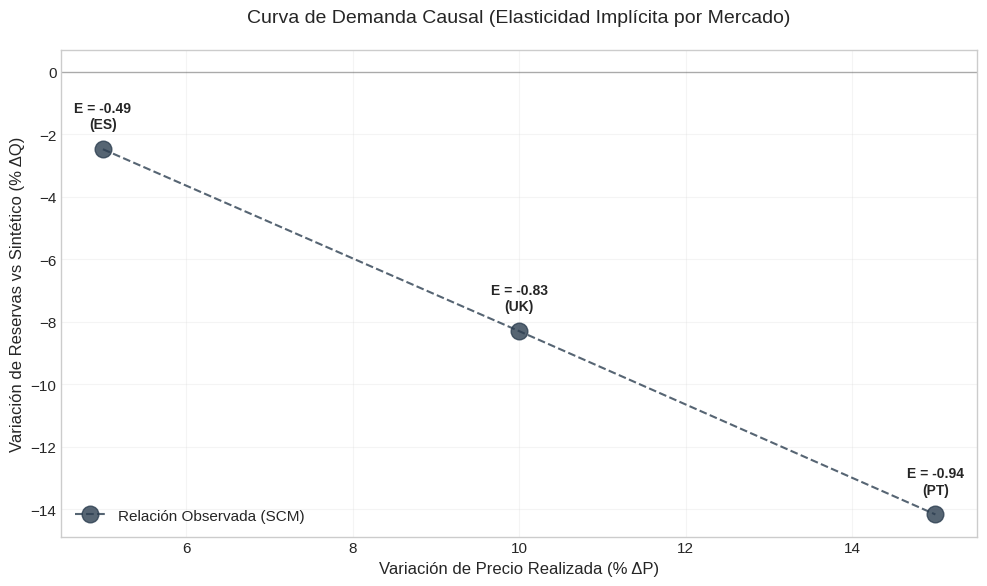


TABLA DE RESULTADOS:


,caso,Mercado,ΔP_Realizado_%,ΔQ_Causal_%,Elasticidad,RMSPE_Pre
0,+5%,ES,5.0,-2.474,-0.495,18.387
1,+10%,UK,10.0,-8.295,-0.830,31.482
2,+15%,PT,15.0,-14.162,-0.944,11.210


In [85]:
# ==============================================================================
# CÁLCULO DE ELASTICIDAD IMPLÍCITA (CAUSAL & REALIZED)
# ==============================================================================

print("ANALISIS DE ELASTICIDAD: %ΔQ CAUSAL / %ΔP REALIZADO")
print("-" * 60)

elasticity_results = []

for arm, info in TREATED_MARKETS.items():
    market = info['representative']
    t_day = info['treatment_day']
    scm_res = results[arm]

    # 1. Extraer datos reales del mercado para el First Stage (%ΔP)
    m_data = df[df['market'] == market].sort_values('day_index')
    pre_mask = m_data['day_index'] < t_day
    post_mask = m_data['day_index'] >= t_day

    # %ΔP Realizado: ¿Cuánto subió el precio realmente en ese mercado?
    p_pre = m_data.loc[pre_mask, 'price_eur'].mean()
    p_post = m_data.loc[post_mask, 'price_eur'].mean()
    pct_delta_p = ((p_post - p_pre) / p_pre) * 100

    # 2. %ΔQ Causal: Basado en acumulados (Suma de Gaps / Suma de Sintético)
    # Esto es mucho más estable ante variaciones diarias que la media de medias
    gap_sum = np.sum(scm_res['effect'][post_mask.values])
    synthetic_sum = np.sum(scm_res['synthetic'][post_mask.values])
    pct_delta_q = (gap_sum / synthetic_sum) * 100

    # 3. Elasticidad Implícita
    elasticity = pct_delta_q / pct_delta_p

    elasticity_results.append({
        'caso': arm,
        'Mercado': market,
        'ΔP_Realizado_%': pct_delta_p,
        'ΔQ_Causal_%': pct_delta_q,
        'Elasticidad': elasticity,
        'RMSPE_Pre': scm_res['rmspe_pre']
    })

# DataFrame Final
df_e = pd.DataFrame(elasticity_results)

# --- VISUALIZACIÓN: RELACIÓN DEMANDA-PRECIO ---
plt.figure(figsize=(10, 6))

# Dibujar puntos y línea conectora (Guía visual, no regresión estadística)
plt.plot(df_e['ΔP_Realizado_%'], df_e['ΔQ_Causal_%'],
         marker='o', markersize=12, linestyle='--', color='#2c3e50',
         alpha=0.8, label='Relación Observada (SCM)')

# Anotaciones de Elasticidad y Mercado
for i, row in df_e.iterrows():
    plt.annotate(f"E = {row['Elasticidad']:.2f}\n({row['Mercado']})",
                 (row['ΔP_Realizado_%'], row['ΔQ_Causal_%']),
                 textcoords="offset points", xytext=(0,15),
                 ha='center', fontweight='bold', fontsize=10)

plt.axhline(0, color='black', linewidth=1, alpha=0.3)
plt.title("Curva de Demanda Causal (Elasticidad Implícita por Mercado)", fontsize=14, pad=20)
plt.xlabel("Variación de Precio Realizada (% ΔP)", fontsize=12)
plt.ylabel("Variación de Reservas vs Sintético (% ΔQ)", fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar tabla resumen para auditoría
print("\nTABLA DE RESULTADOS:")
display(df_e[['caso', 'Mercado', 'ΔP_Realizado_%', 'ΔQ_Causal_%', 'Elasticidad', 'RMSPE_Pre']].round(3))

---

## Referencias

1. **Hernan, M. A., & Robins, J. M.** (2020). *Causal Inference: What If*. Chapman & Hall/CRC.

2. **Abadie, A., Diamond, A., & Hainmueller, J.** (2010). Synthetic control methods for comparative case studies. *JASA*, 105(490), 493-505.

3. **Facure, M.** (2022). *Causal Inference for the Brave and True*. https://matheusfacure.github.io/python-causality-handbook/

---

*Notebook creado siguiendo principios de inferencia causal rigurosa.*